In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,sigma):
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.iP=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim),cov=sigma**2)
        self.iS=lambda size: mvnorm.rvs(size=size,mean=np.zeros(dim),cov=sigma**2)
        
    def __estimate(self,W,name,asym=True):
        Z=np.mean(W)
        err=np.abs(Z-1)
        if asym:
            aVar=np.var(W)
            aErr=np.sqrt(aVar/W.size)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}'.format(name,Z,err,aVar,aErr))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,Z,err))
        
    def estimate_IS(self,size):
        S=self.iS(size)
        W=self.T(S)/self.iP(S)
        self.__estimate(W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        ratio=np.reshape(self.T(np.zeros(self.dim))/P(np.zeros([1,self.dim])),1)[0]
        print('------------ pdf ratio at origin: {:.2f} ------------'.format(ratio))
        
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=rW.size,weights=rW/rW.max()*P(np.zeros([1,self.dim]))[0])
            ax.legend(['target','nonparametric proposal','mixture proposal','centers'])
        elif name=='regression':
            G=self.G(X).T
            rPO=G.dot(self.regO.coef_)+self.regO.intercept_*P(X)
            rPL=G.dot(self.regL.coef_)+self.regL.intercept_*P(X)
            mid=int(x.size/2)
            print('regression ratios: ordinary {:.4f}, lasso {:.4f}'\
                  .format(self.T(X[mid])/rPO[mid],self.T(X[mid])/rPL[mid]))
            
            ax.plot(x,rPO)
            ax.plot(x,rPL)
            ax.legend(['target','mixture proposal','ordinary regression','lasso regression'])
        else:
            ax.legend(['target','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.T(S)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resample rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,rate,bdwth='scott'):
        if(type(bdwth)==str):
            tmp=sciKDE(self.rS.T,bw_method=bdwth)
            bdwth=np.mean(np.sqrt(np.diag(tmp.covariance_factor()*np.cov(self.rS.T))))
            print('bdwth: {:.4f}'.format(bdwth))
        
        self.bdwth=bdwth
        self.kde=sklKDE(kernel='gaussian',bandwidth=bdwth).fit(self.rS)
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=self.bdwth**2)
        self.G=lambda x: np.array([self.h(x,loc) for loc in self.rSset])-self.iP(x)
        
        self.nP=lambda x: np.exp(self.kde.score_samples(x))
        self.nS=lambda size: self.kde.sample(size)
        S=self.nS(size)
        W=self.T(S)/self.nP(S)
        self.__estimate(W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(W,'MIS')
        
    def estimate_RIS(self,alpha):
        X=(self.G(self.S)/self.mP(self.S)).T
        y=self.T(self.S)/self.mP(self.S)
        self.regO=Linear().fit(X,y)
        self.regL=Lasso(alpha).fit(X,y)
        print('Ord: R2: {:.4f}; intercept: {:.4f}; err: {:.4f}'\
              .format(self.regO.score(X,y),self.regO.intercept_,np.abs(self.regO.intercept_-1)))
        print('Las: R2: {:.4f}; intercept: {:.4f}; err: {:.4f}'\
              .format(self.regL.score(X,y),self.regL.intercept_,np.abs(self.regL.intercept_-1)))
        
        newS=self.mS(self.S.shape[0])
        newX=(self.G(newS)/self.mP(newS)).T
        newy=self.T(newS)/self.mP(newS)
        W=newy-newX.dot(self.regO.coef_)
        self.__estimate(W,'RIS(Ord,unbiased)')
        W=newy-newX.dot(self.regL.coef_)
        self.__estimate(W,'RIS(Las,unbiased)')
    
    def estimate_MLE(self,opt=False):
        mP=self.mP(self.S)
        G=self.G(self.S).T
        target=lambda zeta: -np.mean(np.log(mP+G.dot(zeta)))
        gradient=lambda zeta: -np.mean(G.T/(mP+G.dot(zeta)),axis=1)
        zeta0=np.zeros(G.shape[1])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=G.T/mP
        XX=X-X.mean(axis=1,keepdims=True)
        zeta1=np.linalg.solve(XX.dot(XX.T),X.sum(axis=1))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-zeta1.dot(XX))
        self.__estimate(W,'RIS(The)',asym=False)
        W=self.T(self.S)/(mP+G.dot(zeta1))
        self.__estimate(W,'MLE(The)',asym=False)
        
        if opt:
            if(all(mP+G.dot(zeta1)>0)):
                zeta=zeta1
            else:
                zeta=zeta0

            begin=dt.now()
            cons=({'type':'ineq','fun':lambda zeta: mP+G.dot(zeta),'jac':lambda zeta: G})
            res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                         options={'ftol':1e-10,'maxiter':1000})
            end=dt.now()
            print()
            print('Optimization results:')
            print('MLE nit: {}, spent {} seconds! '.format(res['nit'],(end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('distance(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+G.dot(zeta))
                self.__estimate(W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

# Run the experiments

## Initial proposal and the curse of dimensionality

IS est: 0.9477; err: 0.0523; a-var: 15.8279; a-err: 0.0281
------------ pdf ratio at origin: 128.00 ------------


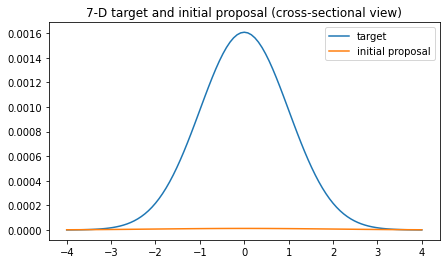

In [3]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')

## KDE with different dimension and initial proposal

IS est: 1.0253; err: 0.0253; a-var: 18.4893; a-err: 0.0304
------------ pdf ratio at origin: 128.00 ------------


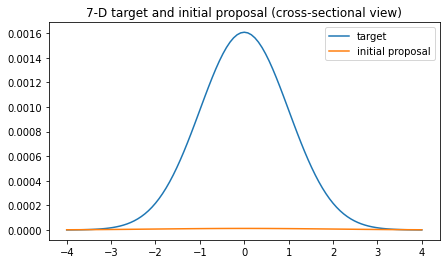

resample rate: 156/200
bdwth: 0.8096
NIS est: 0.9869; err: 0.0131; a-var: 1.5491; a-err: 0.0088
MIS est: 1.0028; err: 0.0028; a-var: 1.7736; a-err: 0.0094
------------ pdf ratio at origin: 6.55 ------------


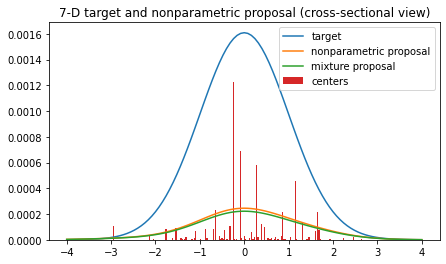

In [4]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')

## Regression performance visualization

IS est: 0.9903; err: 0.0097; a-var: 16.1223; a-err: 0.0284
------------ pdf ratio at origin: 128.00 ------------


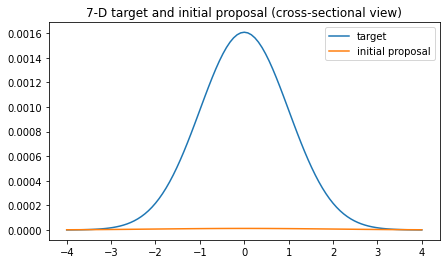

resample rate: 142/200
bdwth: 0.7814
NIS est: 1.0049; err: 0.0049; a-var: 1.0213; a-err: 0.0071
MIS est: 1.0140; err: 0.0140; a-var: 1.2081; a-err: 0.0078
------------ pdf ratio at origin: 3.69 ------------


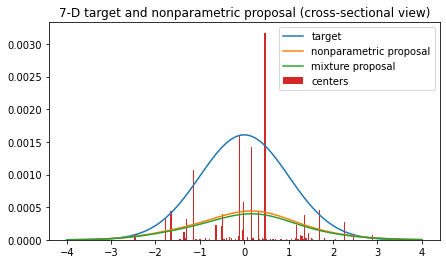

Ord: R2: 0.6473; intercept: 1.0063; err: 0.0063
Las: R2: 0.6262; intercept: 1.0079; err: 0.0079
RIS(Ord,unbiased) est: 1.0013; err: 0.0013; a-var: 0.4059; a-err: 0.0045
RIS(Las,unbiased) est: 1.0008; err: 0.0008; a-var: 0.4296; a-err: 0.0046
------------ pdf ratio at origin: 4.08 ------------
regression ratios: ordinary 1.1358, lasso 1.2673


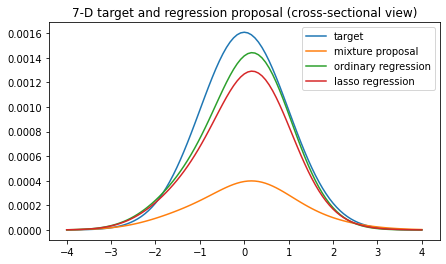

In [5]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')

## MLE method investigation

IS est: 0.9893; err: 0.0107; a-var: 16.8809; a-err: 0.0291
------------ pdf ratio at origin: 128.00 ------------


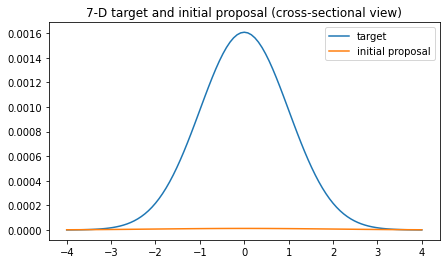

resample rate: 132/200
bdwth: 0.7571
NIS est: 1.0001; err: 0.0001; a-var: 0.9459; a-err: 0.0069
MIS est: 1.0091; err: 0.0091; a-var: 1.0833; a-err: 0.0074
------------ pdf ratio at origin: 4.11 ------------


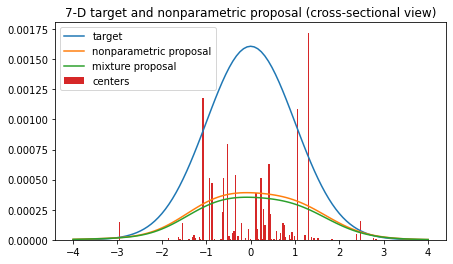

Ord: R2: 0.6356; intercept: 1.0057; err: 0.0057
Las: R2: 0.6100; intercept: 1.0069; err: 0.0069
RIS(Ord,unbiased) est: 0.9995; err: 0.0005; a-var: 0.3943; a-err: 0.0044
RIS(Las,unbiased) est: 0.9996; err: 0.0004; a-var: 0.4182; a-err: 0.0046
------------ pdf ratio at origin: 4.55 ------------
regression ratios: ordinary 1.4623, lasso 1.6384


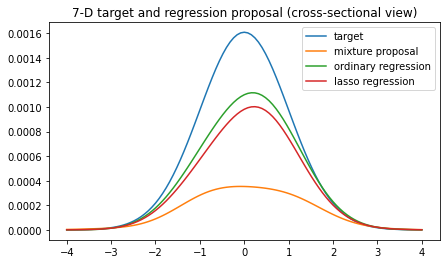

Reference:
origin: value: 11.5449; grad: (min -0.1396, mean 0.0076, max 0.1939, std 0.0518)

Theoretical results:
MLE(The) zeta: (min -0.0094, mean -0.0000, max 0.0064, std 0.0016, norm 0.0185)
theory: value: 11.5419; grad: (min -0.1433, mean -0.0052, max 0.0031, std 0.0139)
RIS(The) est: 1.0057; err: 0.0057
MLE(The) est: 1.0040; err: 0.0040

Optimization results:
MLE nit: 35, spent 10 seconds! 
MLE(Opt) zeta: (min -0.0079, mean -0.0000, max 0.0062, std 0.0015, norm 0.0175)
distance(zeta(Opt),zeta(The))=0.0024
optimal: value: 11.5418; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
MLE(Opt) est: 1.0048; err: 0.0048


In [6]:
mle=MLE(dim=7,sigma=2)
size=20000
mle.estimate_IS(size)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(200,20)
mle.estimate_NIS(size,0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS(0.1)
mle.draw_TP(mle.mP,x,'regression')
print('=======================================================')
mle.estimate_MLE(True)